Loading data...
Data loaded successfully.
Downsampling data to balance classes...
Downsampling completed.
Visualizing class distribution...


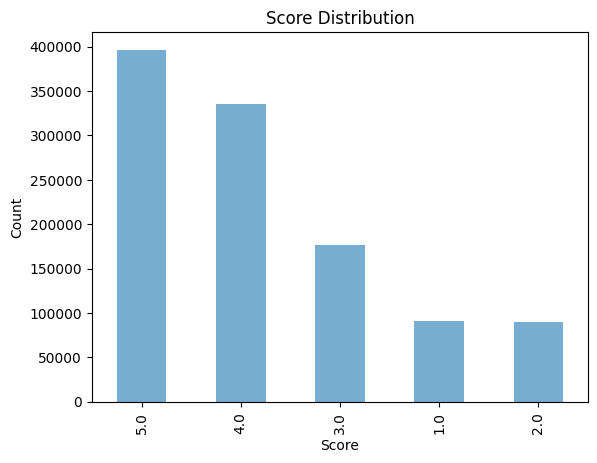

Applying One-Hot Encoding...
One-Hot Encoding completed.
Preprocessing data: Imputing and Standardizing...
Data preprocessing completed.
Calculating TF-IDF for Text column...
TF-IDF calculation for Text completed.
Calculating TF-IDF for Summary column...
TF-IDF calculation for Summary completed.
Concatenating all feature matrices...
Feature concatenation completed.
Splitting data into training and testing sets...
Data split completed.
Starting cross-validation...
Training fold 1/10...


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix

def load_data(file_path):
    print("Loading data...")
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
    return data

def visualize_class_distribution(data, target_col='Score'):
    print("Visualizing class distribution...")
    data[target_col].value_counts().plot(kind='bar', alpha=0.6)
    plt.title(f'{target_col} Distribution')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()

def downsample_class(data, target_col='Score', class_value=5, downsample_frac=0.5):
    print("Downsampling data to balance classes...")
    fives = data[data[target_col] == class_value].sample(frac=downsample_frac, random_state=42)
    data = pd.concat([data[data[target_col] != class_value], fives], ignore_index=True)
    print("Downsampling completed.")
    visualize_class_distribution(data)
    return data

def encode_categorical_features(data, columns):
    print("Applying One-Hot Encoding...")
    OHE = OneHotEncoder(sparse_output=True)
    encoded_data = OHE.fit_transform(data[columns])
    print("One-Hot Encoding completed.")
    return encoded_data, OHE

def preprocess_data(data):
    print("Preprocessing data: Imputing and Standardizing...")
    data.fillna({'Text': '', 'Summary': ''}, inplace=True)
    data['Helpful'] = data['HelpfulnessNumerator']
    data['Unhelpful'] = data['HelpfulnessDenominator'] - data['HelpfulnessNumerator']
    scaler = StandardScaler()
    data[['Helpful', 'Unhelpful', 'Time']] = scaler.fit_transform(data[['Helpful', 'Unhelpful', 'Time']])
    data.drop(['HelpfulnessDenominator', 'HelpfulnessNumerator'], axis=1, inplace=True)
    print("Data preprocessing completed.")
    return data

def calculate_tfidf(data, column):
    print(f"Calculating TF-IDF for {column} column...")
    vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
    matrix = vectorizer.fit_transform(data[column])
    print(f"TF-IDF calculation for {column} completed.")
    return matrix, vectorizer

def prepare_features(data, encoded_ids, text_matrix, summary_matrix):
    print("Concatenating all feature matrices...")
    numerical = scipy.sparse.csr_matrix(data[['Helpful', 'Unhelpful', 'Time']].values)
    X = scipy.sparse.hstack([text_matrix, summary_matrix, numerical, encoded_ids])
    print("Feature concatenation completed.")
    return X

def split_data(X, data, target_col='Score'):
    print("Splitting data into training and testing sets...")
    mask = data[target_col].isnull()
    ind_test = mask.to_numpy().nonzero()[0]
    ind_train = (~mask).to_numpy().nonzero()[0]
    train_X = scipy.sparse.csr_matrix(X)[ind_train]
    test_X = scipy.sparse.csr_matrix(X)[ind_test]
    train_Y = data[target_col].loc[~mask].reset_index(drop=True)
    print("Data split completed.")
    return train_X, test_X, train_Y

def extract_important_words(vectorizer, model):
    print("Extracting important words...")
    feature_names = vectorizer.get_feature_names_out()
    coefficients = model.coef_.flatten()
    
    # Debugging check for length mismatch
    if len(feature_names) != len(coefficients):
        print("Mismatch in lengths:")
        print("Length of feature_names:", len(feature_names))
        print("Length of coefficients:", len(coefficients))
        return  # Exit to avoid the ValueError

    important_words = pd.DataFrame({'word': feature_names, 'coefficient': coefficients})
    important_words = important_words.reindex(important_words['coefficient'].abs().sort_values(ascending=False).index)
    
    # Display top positive and negative words
    print("Top Positive Words:", important_words.head(10))
    print("Top Negative Words:", important_words.tail(10))


def cross_validate_logistic(k, X, y, vectorizer):
    print("Starting cross-validation...")
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    total_mse = 0
    all_predictions = []
    all_true_labels = []

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        print(f"Training fold {fold}/{k}...")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = LogisticRegression(random_state=0, max_iter=1000)
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_test_pred)
        total_mse += mse
        all_predictions.extend(y_test_pred)
        all_true_labels.extend(y_test)
        
        print(f"Fold {fold} MSE: {mse}")
    
    average_mse = total_mse / k
    print("Cross-validation completed.")
    print("Average MSE:", average_mse)

    # Confusion Matrix Visualization
    cm = confusion_matrix(all_true_labels, all_predictions, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    extract_important_words(vectorizer, model)
    return model, average_mse

def main():
    data = load_data('train.csv')
    data = downsample_class(data)
    encoded_ids, OHE = encode_categorical_features(data, ['ProductId', 'UserId'])
    data = preprocess_data(data)
    text_matrix, text_vectorizer = calculate_tfidf(data, 'Text')
    summary_matrix, summary_vectorizer = calculate_tfidf(data, 'Summary')
    X = prepare_features(data, encoded_ids, text_matrix, summary_matrix)
    train_X, test_X, train_Y = split_data(X, data)
    model, mse = cross_validate_logistic(10, train_X, train_Y, text_vectorizer)
    predict_and_save(model, test_X)

def predict_and_save(model, test_X):
    print("Making predictions and saving to CSV...")
    df_test = pd.read_csv('test.csv')
    sample = pd.read_csv('sample.csv')
    predict_df = pd.DataFrame(sample)
    predict_df['Score'] = model.predict(test_X)
    predict_df.to_csv('predicted_scores_logistic.csv', index=False)
    print("Predictions saved to 'predicted_scores_logistic.csv'")

if __name__ == "__main__":
    main()
